In [48]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
#%%
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 10
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure(figsize=(8, 4))
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

In [2]:
%matplotlib inline 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#figure_number = 0
data = pd.Series({})
data['raw'] = pd.read_csv("movie_metadata.csv")
#figure_number += 1
#print("Figure: {} - Boxplot for budget and gross".format(figure_number))

In [5]:
from sklearn.preprocessing import StandardScaler
data['reduced'] = data['raw'][data['raw']['country'] == 'USA']
data['reduced'] = data['reduced'].drop(['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 
                                        'cast_total_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes',
                                        'aspect_ratio', 'facenumber_in_poster'], axis=1)
data['reduced'] = data['reduced'].dropna()
data['numerical'] = data['reduced'].select_dtypes(exclude=['object'])
data['standardized'] = StandardScaler().fit_transform(data['numerical'].values)
data['standardized'] = pd.DataFrame(data['standardized'], columns=data['numerical'].columns.values)

In [6]:
#budget_top15 = data['reduced']['budget'].nlargest(15).keys()
#data['reduced'].loc[budget_top15][['movie_title', 'country', 'budget', 'gross']]

In [7]:
#gross_top15 = data['reduced']['gross'].nlargest(15).keys()
#data['reduced'].loc[gross_top15][['movie_title', 'country', 'budget', 'gross']]

# Regression (Christian)

We want to create two models for our regression analysis. A simple model using linear regression which will serve as our baseline prediction, and a more advanced neural network. For both our model, we first standardize our numerical data, and split our dataset into seperate training and test sets with a test-to-train ratio of 0.25.

In [8]:
from sklearn.model_selection import train_test_split

X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
## 2. Apply linear regression with forward selection and consider if transforming or combining attributes potentially may be useful. For linear regression, plotting the residual error vs. the attributes can give some insight into whether including a transformation of a variable can improve the model, i.e. potentially describe parts of the residuals.

## Linear Regression

<b>Forward feature selection</b><br>
Before creating our linear model, we want to check which features are the most significant. We can do this with forward selection. With this method of feature selection an unused feature, which gives the largest descrease in error, is added to the regression model. When there are no features left that descrease the error, or all features are allocated, the iteration is over. We will do forward selection for 5 iterations and investigate what features our model should be using.

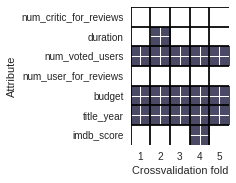

In [10]:
# exercise 6.2.1
from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import cross_validation
from toolbox_02450 import feature_selector_lr, bmplot
import numpy as np

# Load data from dataset
X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

attributeNames = X.columns.values
N, M = X.shape


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = cross_validation.KFold(N,K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV:
    
    # extract training and test set for current CV fold
    X_train = X.values[train_index,:]
    y_train = y.values[train_index]
    X_test = X.values[test_index,:]
    y_test = y.values[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    #textout = 'verbose';
    textout = '';
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    '''
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')
    
    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))
    ''';
    k+=1


# Display results
'''
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))
''';
figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual
'''
f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X.values[:,ff], y)
    
    y_est= m.predict(X.values[:,ff])
    residual=y-y_est
    
    figure(k+1)
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2,np.ceil(len(ff)/2.0),i+1)
       plot(X.values[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
    show()    
''';

In the crossvalidation graph we can see that a model with: 'title_year', 'budget', 'num_voted_users' and 'duration' yields the best result.

<b>Residual analysis</b><br>
As a final analysis before creating our linear model, we can investigate the residual distributions for features selected in a crossvalidation fold.

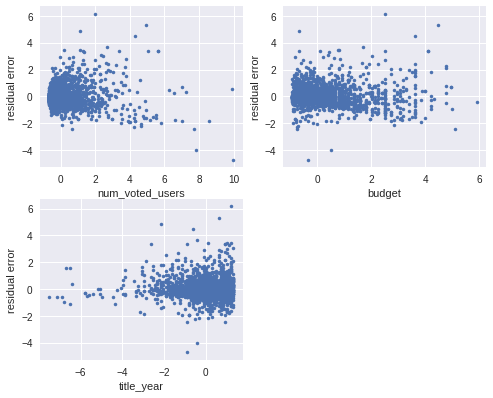

In [11]:
# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=3 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X.values[:,ff], y)
    
    y_est= m.predict(X.values[:,ff])
    residual=y-y_est
    figure(figsize=(8,6.5))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2,np.ceil(len(ff)/2.0),i+1)
       plot(X.values[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')    
    show()    

When we look at the residual graphs we can see that there is no immediately visible pattern and residuals seem to be clustered around 0. It does seem that the residuals for 'num_votes_users' and 'title_year' has a somewhat heteroscedastic. While this might not be a problem, it might be worth considering if further experimentation with feature transformation might improve the model.

<b>Linear Model baseline prediction</b><br>
We now have everything we need to create our linear model. To calculate our error rate we will use the mean squared error method, comparing the predicted against the true values from our test set.

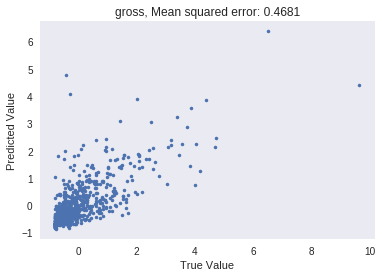

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]

#X = data['standardized'].drop('gross', axis=1)
y = data['standardized'][['gross']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
error = mean_squared_error(y_test, y_pred)

# Visualize prediction against true value
plt.figure(figsize=(6,4))
plt.plot(y_test,y_pred,'.')
plt.grid()
plt.title('{0}, Mean squared error: {1:.04f}'.format(y_train.columns[0], error))
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.show()

With a mean squared error of 0.4681 our model isn't great at predicting, but hopefully we can create a better prediction with the neural network.

In [13]:
## 3. Explain how a new data observation is predicted according to the estimated model. I.e. what are the effects of the selected attributes in terms of predicting the data. (Notice, if you interpret the magnitude of the estimated coefficients this in general requires that each attribute be normalized prior to the analysis.).

<b>Prediction method</b><br>
The model is now able to predict the gross of a movie based on four features: 'title_year', 'budget', 'num_voted_users' and 'duration'. This prediction is calculated based on a bias called the intercept, and one scalar weight for each feature. The prediction is calculated by summing up all weight and feature product, and adding the intercept. We can get a better overview of exactly how much each feature contributes, by showing the weights in a table and a graph.

title_year       :	-0.0567
budget           :	0.4946
num_voted_users  :	0.4912
duration         :	-0.0936


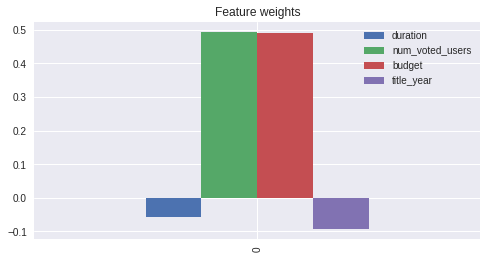

In [14]:
for feature in zip(['title_year', 'budget', 'num_voted_users', 'duration'], lm.coef_[0]):
    print("{:17}:\t{:.4f}".format(feature[0], feature[1]))
pd.DataFrame(lm.coef_, columns=X.columns.values.tolist()).plot.bar(grid=True, figsize=(8,4), title='Feature weights');

From the above graph and table we can see that some features contribute significantly less than others. It is of course always possible a better model exists, but according to our feature selection, this is the best model we can make with the features available.

<b>Artificial Neural Network Predictor</b><br>
With a baseline prediction established, we can move on to creating a neural network model. We will use a simple model with a single 15 node layer and a single output node, and since we are working with a regression problem, we will use a linear function as our activation.

Using TensorFlow backend.


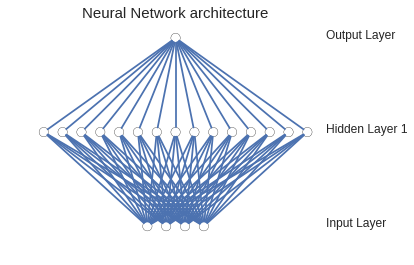

Mean squared error: 0.37128901132201514


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# Feature selection
X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]
y = data['standardized'][['gross']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
shape = X.shape[1]
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model = Sequential()
model.add(Dense(15, input_shape=(shape,), activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[])
history = model.fit(X_train.values, y_train.values, epochs = 30, batch_size=500, shuffle=False, verbose=0)
y_pred = model.predict(X_test.values, batch_size = 1000)
error = mean_squared_error(y_test, y_pred)
network = DrawNN([shape, 15, 1])
network.draw()
print("Mean squared error: {}".format(error))

We can see that the neural network, illustrated above, has an error rate of 0.38, thus an increase in model performance can be achieved by using a neural network instead of a linear classifier, with an error rate of 0.47. The neural network above is fairly simple, and it is possible that even better performance can be reached with a different architecture.

In [17]:
## 5. Statistically evaluate if there is a significant performance difference between the fitted ANN and linear regression models based on the same cross-validation splits (i.e., considering the credibility interval equivalent to the use of a paired t-test as described in lecture 6 and last exercise week 6). Compare in addition if the performance of your models are better than simply predicting the output to be the average of the training data output. 

<b>Model Evaluation and Comparisson</b><br>
To evaluate our two models we want to run them against each other on the same training set and see which model performs best. Since the weights in the neural network models are initiated with random values we should do more than a single round. If we perform a comparisson 50 times, we should be able to estimate how the model will perform compared to the baseline linear prediction.

In [18]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Feature selection
X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']]
y = data['standardized'][['gross']]

lm = LinearRegression()

shape = X.shape[1]
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

scores = []

for n in range(50):
    if (n % 1 == 0):
        pass
        #print(n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    lm.fit(X_train, y_train)
    lm_y_pred = lm.predict(X_test)
    lm_error = mean_squared_error(y_test, lm_y_pred)
    
    model = Sequential()
    model.add(Dense(15, input_shape=(shape,), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=[])
    history = model.fit(X_train.values, y_train.values, epochs=300, batch_size=500, shuffle=False, verbose=0)
    ann_y_pred = model.predict(X_test.values, batch_size = 1000)
    ann_error = mean_squared_error(y_test, ann_y_pred)
    #print("[{}] LinearModel: {}\tANN: {}".format(n, lm_error, ann_error))
    scores.append([lm_error, ann_error])

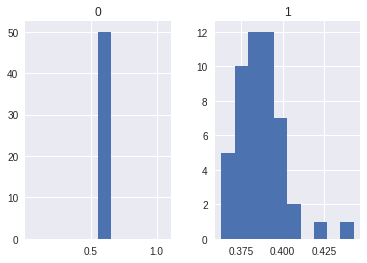

In [19]:
pd.DataFrame(scores).hist();

From the histogram we can see that the neural network has a better performance than our linear model. To further investigate this we can use a t-test and compare the errors from both models, and finally computer a p-value which we can compare to an alpha of 0.05.

Classifiers are significantly different.


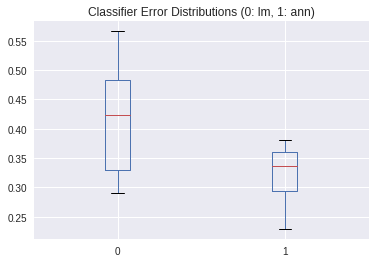

In [20]:
# exercise 6.3.1
from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import cross_validation, tree
from scipy import stats

X = data['standardized'][['duration', 'num_voted_users', 'budget', 'title_year']].values
y = data['standardized'][['gross']].values
N, M = X.shape

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = cross_validation.KFold(N,K,shuffle=True)
#CV = cross_validation.StratifiedKFold(y.A.ravel(),k=K)

# Initialize variables
Error_lm = np.empty((K,1))
Error_ann = np.empty((K,1))

n_tested=0

k=0
for train_index, test_index in CV:
    
    #print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate Logistic Regression classifier
    #model = lm.logistic.LogisticRegression(C=N)
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_lm = lm.predict(X_test)
    #print(y_lm)
    #Error_lm[k] = 100*(y_lm!=y_test).sum().astype(float)/len(y_test)
    #print(Error_lm)
    
    # Fit and evaluate Decision Tree classifier
    #model2 = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train, epochs=60, batch_size=500, shuffle=False, verbose=0)
    y_ann = model.predict(X_test)
    #Error_ann[k] = 100*(y_ann!=y_test).sum().astype(float)/len(y_test)
    Error_lm[k] = mean_squared_error(y_test, y_lm)
    Error_ann[k] = mean_squared_error(y_test, y_ann)
    
    k+=1
    
# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 

z = (lm_error - ann_error)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')
    
# Boxplot to compare classifier error distributions
pd.DataFrame(np.array([Error_lm.flatten(), Error_ann.flatten()]).T).plot.box(title='Classifier Error Distributions (0: lm, 1: ann)');

By statistically comparing the two classifiers with a t-test we can conclude that the models are indeed significantly different. This means that for our dataset, the neural network is better at predicting movie gross, based only on four features.

## Classification

The goal with the classification is to predict wether a movie is good or bad. A good movie will correspond to that a given movie has a 'imdb_score' ≥ 6.  

### Decision Trees: Random Forest Classifier
For classification the first method used on the dataset is the Random Forest Classifier

In [21]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.cross_validation

The numerical part of the dataset is copied into 'CLF' and will be used in the different types of classification.

In [22]:
data['CLF'] = data['numerical'].copy()
data['CLF'].head()

,num_critic_for_reviews,duration,gross,num_voted_users,num_user_for_reviews,budget,title_year,imdb_score
0,723.0,178.0,760505847.0,886204,3054.0,237000000.0,2009.0,7.9
1,302.0,169.0,309404152.0,471220,1238.0,300000000.0,2007.0,7.1
3,813.0,164.0,448130642.0,1144337,2701.0,250000000.0,2012.0,8.5
5,462.0,132.0,73058679.0,212204,738.0,263700000.0,2012.0,6.6
6,392.0,156.0,336530303.0,383056,1902.0,258000000.0,2007.0,6.2


The features for the classification will be all attributes from 'CLF' except 'imdb_score' which will be the target for the classification.

In [23]:
X = data['CLF'].drop('imdb_score', axis =1)

Since 'imdb_score' will be the target but the problem is simplified as a binary problem, movies with an 'imdb_score' lesser than 6 will be classified as a "bad" movie, and an imdb_score greater or equal than 6 are classified as a "good" movie. 

In [24]:
data['CLF']['imdb_score'] = np.where(data['CLF']['imdb_score'] > 5.9, 1,0)
Y = data['CLF']['imdb_score']

Train and test set is created, with a test size of 10 % of the data.

From sklearn's train_test_split function 'is_train' is added to the data set, with a booloen value of True or False.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.10)

Now the goal can be described as predicting the target Y (quality of the movie) as a function of all the features X.

Now "random forest classifier" will be used to classify the quality of the movie.
From scikit-learn the cross_val_score() function is used to plot all the different scores from the random forests, from 1 which is the simplest decision tree up  to 20.
10-fold cross validation is used as validation.  

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import datetime

#now = datetime.datetime.now()
    
scores = []

for val in range (1,21):
    clf = RandomForestClassifier(n_estimators = val)
    validated = cross_val_score(clf, X_train, y_train, cv = 10)
    scores.append(validated)
    
#print(datetime.datetime.now()-now)

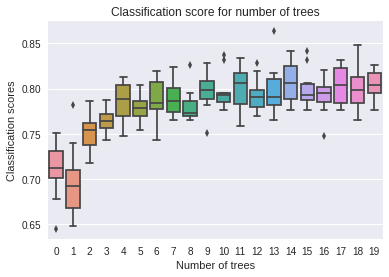

In [27]:
sns.boxplot(data = scores)
plt.xlabel('Number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')
plt.show()

On the above plot it seems like the classification score seems to be pretty good with more than 5 trees, and  above they don't differ that much. 10 trees is chosen to secure a good classification score on further computations.

Now it could be interresting to see how many movies are labeled as good, since it's binary classification problem the classification score could be misleading if for example "good" movies appeared way to frequent.

In [28]:
len_y = len(y_train)
temp = [i for i in y_train if i == 1]
temp_1 = temp.count(1)

percentage = float(temp_1)/float(len_y)*100

print("Percentage of movies labeled good: %0.2f" %(percentage), "%")



Percentage of movies labeled good: 69.61 %


The prediction probabilities can also be found from the random forest clasifier with predict_proba(). Following shows the predicted probabilities of the first 10 observations, from where it's possible to see how confident the classifier is about 'bad' and 'good' movies. 
Probabilities > 0.5 is predicted. 

In [29]:
clf = RandomForestClassifier(n_estimators= 10)
clf.fit(X_train,y_train)
pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)[0:3]

,0,1
0,0.0,1.0
1,0.1,0.9
2,0.0,1.0


Since the different features are used to predict the target, it could be interresting to see the importance of the different feautures. And from that find out which attributes can be neglected in prediction wether a movie is 'bad' or 'good'.   

<function matplotlib.pyplot.show>

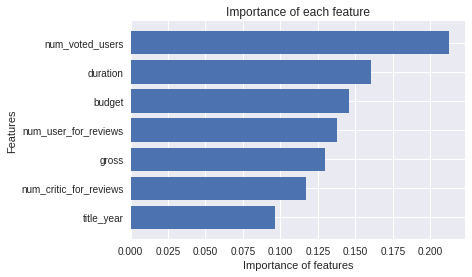

In [31]:
clf.fit(X_train,y_train)

imp = clf.feature_importances_
names = data['CLF'].columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show

'num_voted_users' is the most important feature and contribute more than twice to the prediction than 'title_year'.

Now the model is used on the test set, and the accuracy of the model is then calculated.

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf.fit(X_test, y_test), X, Y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.77 (+/- 0.04)


With an accuracy of 77 % the Random Forest Classifier seems pretty good at predicting the quality of the movie. 

In [33]:
## Naive bayes
#The same classification problem will now be done with Naive Bayes

from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
# The Naive Bayes classifier model is initialized
clfNB = GaussianNB() 
# 10 fold crossvalidation is performed on the fitted model
validatedNB = cross_val_score(clf, X_train, y_train, cv = 10)
#print("Accuracy: %0.2f (+/- %0.2f)" % (validatedNB.mean(), validatedNB.std() * 2))

### Decision Trees

To compare two different types of classifiers basic Decision Trees are now used. This will be done by implementing given scripts from previous excercises with a few tweaks, so that the wanted comparison can be done with paired t-test. 

In [35]:
from sklearn import cross_validation, tree
#### two layer cross validation decision tree
#select X and Y                                                
X = X_train
y = y_train

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 30, 1)

# K-fold crossvalidation setup
K = 10
CV = cross_validation.KFold(X.shape[0],K,shuffle=True)

# Initialize variable
TREE_Error_train = np.empty((len(tc),K))
TREE_Error_test = np.empty((len(tc),K))

#Outer loop (Kfold)
k=0
for train_index, test_index in CV:
    # Print info on progress
    #print('Computing CV fold: {0}/{1}..'.format(k+1,K))
    
    # get train and test values for current KFold
    X_train, y_train = X.iloc[train_index,:], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index,:], y.iloc[test_index]
    
    # inner loop (model selection)
    for i, t in enumerate(tc):
        
        # clasify
        clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
        clf = clf.fit(X_train, y_train)

        #predict
        y_est_test = clf.predict(X_test)
        y_est_train = clf.predict(X_train)
    
        #evaluate misclasification in the current Kfold
        misclass_rate_test = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))
        TREE_Error_test[i,k], TREE_Error_train[i,k] = misclass_rate_test, misclass_rate_train
    
    # increment kfold counter
    k+=1

The complexity of the model is now plotted vs the test error and the misclassification rate for the different folds. 

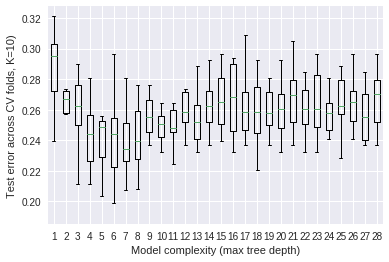

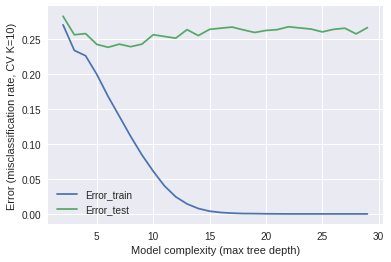

In [40]:
f = plt.figure(); f.hold(True)
plt.boxplot(TREE_Error_test.T)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Test error across CV folds, K={0})'.format(K))

f = plt.figure(); f.hold(True)
plt.plot(tc, TREE_Error_train.mean(1))
plt.plot(tc, TREE_Error_test.mean(1))
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K))
plt.legend(['Error_train','Error_test'])
    
plt.show()

On the above plots it's seen that the model don't get better with higher complexity. And the best model is already found with 5 trees.

### K-nearest neighbor

Now K-nearest neighbor are used, and will again be implemented from the given scripts, so that the wanted comparison can be done with paired t-test. 

In [43]:
import datetime
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
#### two layer cross validation K-nearest neighbor
#select X and Y                                                
X = X_train
y = y_train

# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 30, 1)

# K-fold crossvalidation setup
K = 10
CV = cross_validation.KFold(X.shape[0],K,shuffle=True)

# Initialize variable
KN_Error_train = np.empty((len(tc),K))
KN_Error_test = np.empty((len(tc),K))

#Outer loop (Kfold)
k=0
for train_index, test_index in CV:
    # Print info on progress
    #now = datetime.datetime.now()
    #print(now)
    #print('Computing CV fold: {0}/{1}..'.format(k+1,K))
    
    # get train and test values for current KFold
    X_train, y_train = X.iloc[train_index,:], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index,:], y.iloc[test_index]
    
    # inner loop (model selection)
    for i, t in enumerate(tc):
        
        # clasify
        neigh = KNeighborsClassifier(n_neighbors=t)
        neigh.fit(X_train, y_train) 

        #predict
        y_est_test = neigh.predict(X_test)
        y_est_train = neigh.predict(X_train)
    
        #evaluate misclasification in the current Kfold
        misclass_rate_test = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))
        KN_Error_test[i,k], KN_Error_train[i,k] = misclass_rate_test, misclass_rate_train
    
    # increment kfold counter
    k+=1

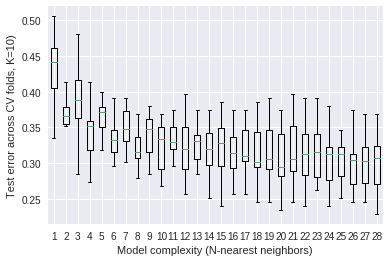

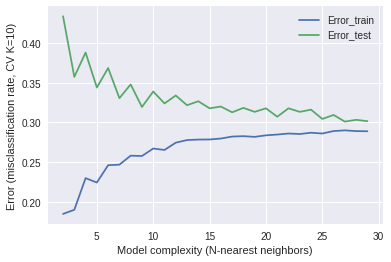

In [44]:
f = plt.figure(); f.hold(True)
plt.boxplot(KN_Error_test.T)
plt.xlabel('Model complexity (N-nearest neighbors)')
plt.ylabel('Test error across CV folds, K={0})'.format(K))

f = plt.figure(); f.hold(True)
plt.plot(tc, KN_Error_train.mean(1))
plt.plot(tc, KN_Error_test.mean(1))
plt.xlabel('Model complexity (N-nearest neighbors)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K))
plt.legend(['Error_train','Error_test'])
    
plt.show()

It's seen on the plot that the model performs better as the number of nearest neigbors increases up to a number around 16, where more neigbors doesn't effect the model more. 

### Artificial Neural Network

For the classification problem, an Artificial Network is now implemented.

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from sklearn import cross_validation
import datetime

#select X and Y                                                
X = X_train
y = y_train
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 15, 1)

# K-fold crossvalidation setup
K = 10
CV = cross_validation.KFold(X.shape[0],K,shuffle=True)

# Initialize variable
NN_Error_train = np.empty((len(tc),K))
NN_Error_test = np.empty((len(tc),K))

#Outer loop (Kfold)
k=0
for train_index, test_index in CV:
    # Print info on progress
    #now = datetime.datetime.now()
    #print(now)
    #print('Computing CV fold: {0}/{1}..'.format(k+1,K))
    
    # get train and test values for current KFold
    X_train, y_train = X.iloc[train_index,:], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index,:], y.iloc[test_index]
    
    # inner loop (model selection)
    for i, t in enumerate(tc):
        
        model = Sequential()

        # adding layers
        model.add(Dense(t*10, activation='relu', input_dim=X_train.shape[1],))
        model.add(Dense(t*5, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # tweaking settings
        adam = optimizers.Adam(lr=0.001, beta_1=0.9,
        beta_2=0.999, epsilon=1e-08, decay=0.0)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

        # fitting model
        history = model.fit(X_train.values,y_train.values, validation_data=(X_test.values,y_test.values),
        epochs = 25, batch_size=500, shuffle=False,verbose=0)
        
        # predict
        y_est_test = model.predict(X_test.values, batch_size = 1000).reshape((-1,))
        y_est_train = model.predict(X_train.values, batch_size = 1000).reshape((-1,))
    
        #evaluate misclasification in the current Kfold
        misclass_rate_test = sum(np.abs(y_est_test - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(y_est_train - y_train)) / float(len(y_est_train))
        NN_Error_test[i,k], NN_Error_train[i,k] = misclass_rate_test, misclass_rate_train
    
    # increment kfold counter
    k+=1

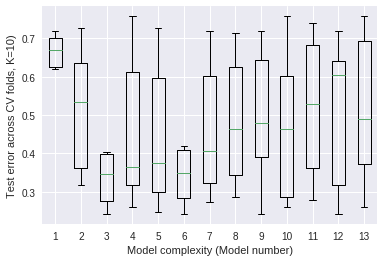

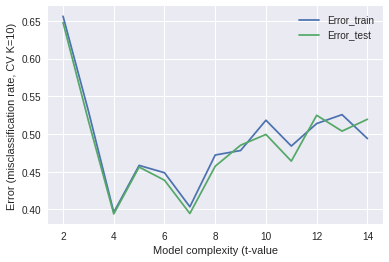

In [46]:
f = plt.figure()
plt.boxplot(NN_Error_test.T)
plt.xlabel('Model complexity (Model number)')
plt.ylabel('Test error across CV folds, K={0})'.format(K))

f = plt.figure()
plt.plot(tc, NN_Error_train.mean(1))
plt.plot(tc, NN_Error_test.mean(1))
plt.xlabel('Model complexity (t-value')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K))
plt.legend(['Error_train','Error_test'])
    
plt.show()

On the above plots it's clearly seen that the Artificial Neural Network overall is the worst of all the implemented models. And only model number 3 and 6 is compare with the Decision Trees or the K-nearest neighbor models.

## Evaluation

In [47]:
from scipy import stats
kn_test = KN_Error_test.T[:,2]
tree_test = TREE_Error_test.T[:,25]
[tstatistic, pvalue] = stats.ttest_ind(kn_test,tree_test)
alpha = 0.05
if pvalue <= alpha:
    print('Classifiers are not significantly different')        
else:
    print('Classifiers are significantly different.')

Classifiers are not significantly different


With scipy's library stats, it's possible to make a paired t-test on the Decision tree and the K-nearest Neigbors test set. 
And with a significant level of 0.05 the two models are not significant different.